# Indiana Groundwater Chemistry

All of Indiana is above the Wabash basin, a subbasin of the Missippi river. This notebook looks at a historical groundwater chemistry dataset. Published by the Indiana DNR.

In [35]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import utm


In [3]:
#import data

#set the filepath
gw_filepath = r"C:\Users\janel\OneDrive\Documents\IU grad\Classes F23\EAS 690 Advanced Data Science\G690_Test\research_project\IDNR_GWchem\Data\GWCHEM_AA.xls"

# read in the data file
# dates are listed in seperate columns: 30, 31, 32 for month, day, year
IDNR_gw_full = pd.read_excel(gw_filepath, 
                             sheet_name = "basins", 
                             header = 6, 
                             skiprows = 6,
                             #index_col='date', 
                             parse_dates={'date': [32,30,31]})

# show the top of the dataset
IDNR_gw_full.head()

,date,ref.no,pub.no,samp.no,UTMN,UTME,COUNTY,TOWNSHIP,RANGE,SECTION,...,LEAD,ARS,SEL,BOR,COMMENTS.1,Well type,Ref No.,Unnamed: 59,Sample #,Basin
0,1989-07-19,85,NaN,WF-024,4451775,623650,18,20,9,6,...,NaN,NaN,NaN,NaN,NaN,B,85,NaN,WF-024,WF
1,1989-07-11,1302,NaN,WF-002,4450598,632343,18,20,10,7,...,NaN,NaN,NaN,NaN,NaN,U,1302,NaN,WF-002,WF
2,1989-07-11,1551,NaN,WF-003,4447960,637860,18,20,10,22,...,NaN,NaN,NaN,NaN,NaN,U,1551,NaN,WF-003,WF
3,1989-07-13,2577,NaN,WF-014,4456595,627750,18,21,9,22,...,NaN,NaN,NaN,NaN,NaN,B,2577,NaN,WF-014,WF
4,1989-07-13,2752,NaN,WF-011A,4459750,641860,18,21,10,12,...,NaN,NaN,NaN,NaN,NaN,B,2752,NaN,WF-011A,WF


In [4]:
#convert UTM coordinates to lat lon
IDNR_gw_full['lat'], IDNR_gw_full['lon'] = utm.to_latlon(IDNR_gw_full['UTME'], IDNR_gw_full['UTMN'], 16, northern=True)
IDNR_gw_full.head()

,date,ref.no,pub.no,samp.no,UTMN,UTME,COUNTY,TOWNSHIP,RANGE,SECTION,...,SEL,BOR,COMMENTS.1,Well type,Ref No.,Unnamed: 59,Sample #,Basin,lat,lon
0,1989-07-19,85,NaN,WF-024,4451775,623650,18,20,9,6,...,NaN,NaN,NaN,B,85,NaN,WF-024,WF,40.207272,-85.547048
1,1989-07-11,1302,NaN,WF-002,4450598,632343,18,20,10,7,...,NaN,NaN,NaN,U,1302,NaN,WF-002,WF,40.195345,-85.445177
2,1989-07-11,1551,NaN,WF-003,4447960,637860,18,20,10,22,...,NaN,NaN,NaN,U,1551,NaN,WF-003,WF,40.170698,-85.380950
3,1989-07-13,2577,NaN,WF-014,4456595,627750,18,21,9,22,...,NaN,NaN,NaN,B,2577,NaN,WF-014,WF,40.250068,-85.497927
4,1989-07-13,2752,NaN,WF-011A,4459750,641860,18,21,10,12,...,NaN,NaN,NaN,B,2752,NaN,WF-011A,WF,40.276208,-85.331388


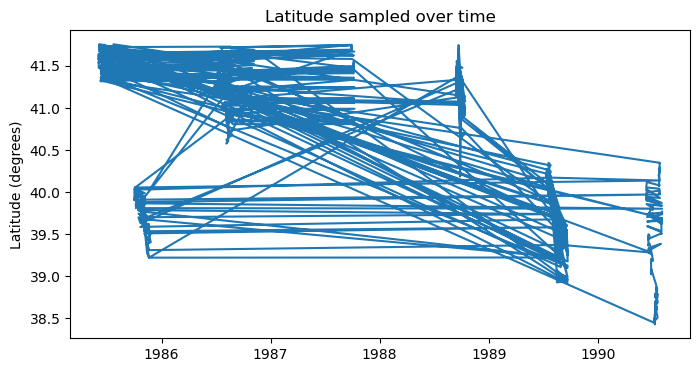

In [9]:
#display data entries over time

""" Create dates and plot the data. """
gw_dates = pd.date_range(start='1985-01-01', end='1991-12-31', freq='d')

#plot the data over time
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(IDNR_gw_full['date'], IDNR_gw_full['lat'])
ax.set_title("Latitude sampled over time")
ax.set_ylabel("Latitude (degrees)")
plt.show()

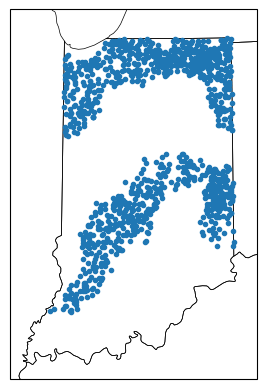

In [34]:
#display data points on map
bloomington_lon = -86.526386
bloomington_lat = 39.165325
projection = cartopy.crs.Orthographic(central_longitude=bloomington_lon, central_latitude=bloomington_lat)
transform = cartopy.crs.PlateCarree()

fig, ax = plt.subplots( subplot_kw= dict(projection = projection))
ax.plot(IDNR_gw_full['lon'], IDNR_gw_full['lat'], '.', transform = transform)
ax.add_feature(cartopy.feature.STATES, linewidth=0.5)
ax.set_extent([-88.3, -84.5, 37.6, 42.1], crs=cartopy.crs.PlateCarree())
plt.show()                  

In [ ]:
#interpolate geochemical parameters